## Load Data

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display_functions import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle

df = pd.read_csv('../data/phishstorm.csv', encoding='iso-8859-1', on_bad_lines='skip')
# rename first column to url
df = df.rename(columns={df.columns[0]: 'url'})
# keep only url and label columns
df = df[['url', 'label']]

print(f'Dropping {df.url.isnull().sum()} empty URL entries from ODP dataset')
df.drop(df[df.url.isnull()].index, inplace=True)
print(f'Dropping {df.label.isnull().sum()} empty label entries from ODP dataset')
df.drop(df[df.label.isnull()].index, inplace=True)

Dropping 0 empty URL entries from ODP dataset
Dropping 92 empty label entries from ODP dataset


/var/folders/rd/k002x01n0gnbs4ysndmgg8d80000gn/T/ipykernel_37996/1247802633.py:12: DtypeWarning: Columns (1,2,3,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/phishstorm.csv', encoding='iso-8859-1', on_bad_lines='skip')


## Preprocessing

In [3]:
df['url'] = df['url'].apply(lambda x: np.str_(x))

## Prepare labels

In [4]:
# label distribution
print(df['label'].value_counts())

label
0.0    48009
1.0    47904
Name: count, dtype: int64


## Transform with count vectorizer

In [5]:
count_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(5, 5))
X = count_vectorizer.fit_transform(df['url'])
y = df['label'].values

X, y = shuffle(X, y, random_state=67)

## Optimize alpha parameter with grid search

In [6]:
sgd = SGDClassifier(class_weight='balanced', loss='hinge')

dist = {'alpha': np.logspace(-7, 1, 10)}
clf = RandomizedSearchCV(sgd, param_distributions=dist, random_state=67, n_jobs=4, cv=5)

start = time.time()
search = clf.fit(X, y)
print(f'\nCV Time: {time.time()-start}')
search.best_params_


CV Time: 7.709682941436768


{'alpha': 4.641588833612772e-05}

## Report results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.531616,0.021466,0.005346,0.001305,0.000046,{'alpha': 4.641588833612772e-05},0.983892,0.984413,0.983683,0.982744,0.983109,0.983568,0.000587,1
4,0.552680,0.042180,0.006212,0.001837,0.000359,{'alpha': 0.00035938136638046257},0.980608,0.982015,0.982537,0.982379,0.982067,0.981921,0.000685,2
2,0.487120,0.028064,0.006065,0.001571,0.000006,{'alpha': 5.994842503189409e-06},0.981755,0.981442,0.980764,0.981180,0.981441,0.981316,0.000331,3
0,0.620220,0.053736,0.010519,0.006384,0.0,{'alpha': 1e-07},0.981650,0.981650,0.981077,0.980711,0.979460,0.980910,0.000808,4
1,0.520190,0.012563,0.005556,0.001155,0.000001,{'alpha': 7.742636826811278e-07},0.980139,0.981442,0.981129,0.980711,0.980294,0.980743,0.000491,5
5,0.447658,0.010903,0.006090,0.002495,0.002783,{'alpha': 0.0027825594022071257},0.967992,0.968305,0.967784,0.967834,0.968147,0.968013,0.000194,6
6,0.402035,0.023000,0.006987,0.002605,0.021544,{'alpha': 0.021544346900318822},0.935776,0.940364,0.940729,0.938432,0.936607,0.938382,0.001969,7
7,0.422338,0.005678,0.006023,0.002051,0.16681,{'alpha': 0.16681005372000557},0.881770,0.885836,0.886201,0.885570,0.873996,0.882675,0.004625,8
8,0.440668,0.049634,0.005127,0.000758,1.29155,{'alpha': 1.2915496650148828},0.872231,0.888495,0.882344,0.886352,0.864613,0.878807,0.009033,9
9,0.526863,0.132478,0.005769,0.002483,10.0,{'alpha': 10.0},0.842725,0.871292,0.864620,0.863674,0.850589,0.858580,0.010385,10


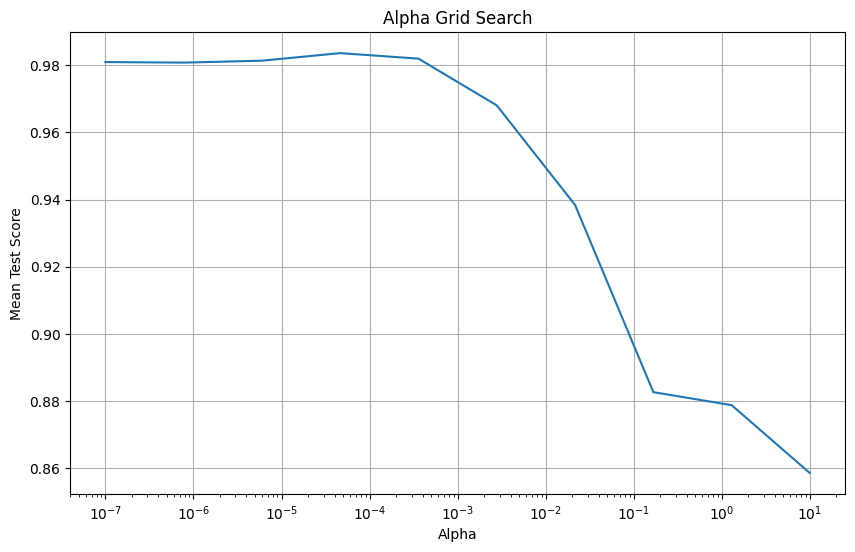

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pd.DataFrame(clf.cv_results_).sort_values('rank_test_score'))
    
plt.figure(figsize=(10, 6))
plt.semilogx(clf.cv_results_['param_alpha'], clf.cv_results_['mean_test_score'])
plt.title('Alpha Grid Search')
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score')
plt.grid()
plt.savefig("../results/charts/phishstorm_gridsearch.png")
plt.show()

## Evaluate best model

In [8]:
from sklearn.model_selection import cross_val_score

sgd = SGDClassifier(class_weight='balanced', loss='hinge', alpha=clf.best_params_['alpha'])
scores = cross_val_score(sgd, X, y, cv=5, n_jobs=4)
print(f'Accuracy: {scores.mean():.2f} (+/- {scores.std()*2:.2f})')

Accuracy: 0.98 (+/- 0.00)


## Write prediction to file (cross-validation)

In [9]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(sgd, X, y, cv=5, n_jobs=4)

df['prediction'] = y_pred
df.to_csv('../results/predictions/phishstorm-predictions.csv', index=False)
